# This repo contains the following:
- Code for CNN-based classification for MNIST Dataset
- Code for Pointnet classification for MNIST3d Dataset
- Code for Fusion-based classification for MNIST and MNIST3D Dataset

In [45]:
# Import libraries
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from matplotlib import pyplot as plt
import h5py
import pandas as pd

tf.random.set_seed(1234)


In [46]:
# gpu_devices = tf.config.experimental.list_physical_devices('GPU')
# for device in gpu_devices:
#     tf.config.experimental.set_memory_growth(device, True)

### Load MNIST Dataset

In [47]:
DATADIR = '../data/multimodal/mnist3d/'

In [48]:
# with h5py.File(DATADIR + 'full_dataset_vectors.h5', 'r') as dataset:
#     X_train = dataset['X_train'][:]
#     X_test = dataset['X_test'][:]
#     y_train = dataset['y_train'][:]
#     y_test = dataset['y_test'][:]

In [49]:
noOfpoints = 2048
BATCH_SIZE = 32
run_type = 'demo'
# run_type = 'full'

NUM_CLASSES = 10
num_classes = NUM_CLASSES
NUM_POINTS = noOfpoints

In [50]:
with h5py.File(DATADIR + 'train_point_clouds.h5', 'r') as points_dataset:

    # Array to store data...
    x_train_2d = []
    x_train_3d = []
    y_train = [] 

    # Looping over the whole dataset..
    for i, (key, sample) in enumerate(points_dataset.items()):
        
        # Saving images...
        x_train_2d.append(sample['img'][:])

        # Sampling point cloud and saving...
        pointCloud = sample['points'][:]
        num_of_rows = pointCloud.shape[0]
        random_ind = np.random.choice(num_of_rows, size=noOfpoints, replace=False)
        pointCloud = pointCloud[random_ind, :]
        x_train_3d.append(pointCloud)

        # Ssaving labels...
        y_train.append(sample.attrs['label'])

# converting to np array...
x_train_2d = np.stack(x_train_2d)
x_train_3d = np.stack(x_train_3d)
y_train = np.array(y_train)

In [51]:
with h5py.File(DATADIR + 'test_point_clouds.h5', 'r') as points_dataset:

    # Array to store data...
    x_test_2d = []
    x_test_3d = []
    y_test = [] 

    # Looping over the whole dataset..
    for i, (key, sample) in enumerate(points_dataset.items()):
        
        # Saving images...
        x_test_2d.append(sample['img'][:])

        # Sampling point cloud and saving...
        pointCloud = sample['points'][:]
        num_of_rows = pointCloud.shape[0]
        random_ind = np.random.choice(num_of_rows, size=noOfpoints, replace=False)
        pointCloud = pointCloud[random_ind, :]
        x_test_3d.append(pointCloud)

        # Ssaving labels...
        y_test.append(sample.attrs['label'])

# converting to np array...
x_test_2d = np.stack(x_test_2d)
x_test_3d = np.stack(x_test_3d)
y_test = np.array(y_test)

In [52]:
# Creating dataset for mnist 3D data...

In [53]:
# adding extra...

total_training_samples = x_train_3d.shape[0]
total_testing_samples = x_test_3d.shape[0]

random_trainig_indices = np.arange(total_training_samples)
np.random.shuffle(random_trainig_indices)

random_testing_indices = np.arange(total_testing_samples)
np.random.shuffle(random_testing_indices)


print(f"No of training samples: {x_train_3d.shape[0]}")
print(f"No of testing samples: {x_test_3d.shape[0]}")


if run_type == 'demo':
    demo_training_samples = 100
    demo_testing_samples = 100

    random_trainig_indices = random_trainig_indices[0:demo_training_samples]
    random_testing_indices = random_testing_indices[0:demo_testing_samples]

x_train_2d_sel = x_train_2d[random_trainig_indices]
x_train_3d_sel = x_train_3d[random_trainig_indices]
y_train_sel = y_train[random_trainig_indices]

x_test_2d_sel = x_test_2d[random_testing_indices]
x_test_3d_sel = x_test_3d[random_testing_indices]
y_test_sel = y_test[random_testing_indices]


# convert class vectors to binary class matrices
y_train_sel_b = keras.utils.to_categorical(y_train_sel, num_classes)
y_test_sel_b = keras.utils.to_categorical(y_test_sel, num_classes)

# Reshaping 2D images to add additional dimension
x_train_2d_sel = x_train_2d_sel.reshape(-1, 30, 30, 1)
x_test_2d_sel = x_test_2d_sel.reshape(-1, 30, 30, 1)

print("After updating...")
print(f"No of training samples: {x_train_3d_sel.shape[0]}")
print(f"No of testing samples: {y_train_sel.shape[0]}")
print("Done...!")

No of training samples: 5000
No of testing samples: 1000
After updating...
No of training samples: 100
No of testing samples: 100
Done...!


In [54]:
train_dataset_2d = tf.data.Dataset.from_tensor_slices((x_train_2d_sel, y_train_sel))
test_dataset_2d = tf.data.Dataset.from_tensor_slices((x_test_2d_sel, y_test_sel))

train_dataset_3d = tf.data.Dataset.from_tensor_slices((x_train_3d_sel, y_train_sel))
test_dataset_3d = tf.data.Dataset.from_tensor_slices((x_test_3d_sel, y_test_sel))



# Adding augment and creating dataset...
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset_2d = train_dataset_2d.shuffle(len(x_train_2d_sel)).map(augment).batch(BATCH_SIZE)
test_dataset_2d = test_dataset_2d.shuffle(len(x_test_2d_sel)).batch(BATCH_SIZE)

train_dataset_3d = train_dataset_3d.shuffle(len(x_train_3d_sel)).map(augment).batch(BATCH_SIZE)
test_dataset_3d = test_dataset_3d.shuffle(len(x_test_3d_sel)).batch(BATCH_SIZE)

In [55]:
train_dataset_2d

<BatchDataset element_spec=(TensorSpec(shape=(None, 30, 30, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [56]:
train_dataset_3d

<BatchDataset element_spec=(TensorSpec(shape=(None, 2048, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

### Build a model

Each convolution and fully-connected layer (with exception for end layers) consits of
Convolution / Dense -> Batch Normalization -> ReLU Activation.

In [57]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

PointNet consists of two core components. The primary MLP network, and the transformer
net (T-net). The T-net aims to learn an affine transformation matrix by its own mini
network. The T-net is used twice. The first time to transform the input features (n, 3)
into a canonical representation. The second is an affine transformation for alignment in
feature space (n, 3). As per the original paper we constrain the transformation to be
close to an orthogonal matrix (i.e. ||X*X^T - I|| = 0).


In [58]:
# class OrthogonalRegularizer(keras.regularizers.Regularizer):
#     def __init__(self, num_features, l2reg=0.001):
#         self.num_features = num_features
#         self.l2reg = l2reg
#         self.eye = tf.eye(num_features)

#     def __call__(self, x):
#         x = tf.reshape(x, (-1, self.num_features, self.num_features))
#         xxt = tf.tensordot(x, x, axes=(2, 2))
#         xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
#         return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

 We can then define a general function to build T-net layers.


In [59]:

def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    # reg = OrthogonalRegularizer(num_features)
    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        # activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])



The main network can be then implemented in the same manner where the t-net mini models
can be dropped in a layers in the graph. Here we replicate the network architecture
published in the original paper but with half the number of weights at each layer as we
are using the smaller 10 class ModelNet dataset.


In [60]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()


Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2048, 32)     128         ['input_7[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2048, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 2048, 32)     0           ['batch_normalization[0][0

### Train model

Once the model is defined it can be trained like any other standard classification model
using `.compile()` and `.fit()`.


In [61]:
# Train the model

batch_size = 20
epochs = 2

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x_train_3d_sel, y_train_sel_b, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/2
5/5 [==============================] - 14s 1s/step - loss: 2.5765 - accuracy: 0.1667 - val_loss: 5.4713 - val_accuracy: 0.2000
Epoch 2/2
5/5 [==============================] - 7s 1s/step - loss: 2.2994 - accuracy: 0.2000 - val_loss: 2.5536 - val_accuracy: 0.1000


In [62]:
# model.compile(
#     loss="sparse_categorical_crossentropy",
#     optimizer=keras.optimizers.Adam(learning_rate=0.001),
#     metrics=["sparse_categorical_accuracy"],
# )

# model.fit(train_dataset_3d, epochs = 10, validation_data=test_dataset_3d)

In [63]:
# Saving model
model.save('models/mnist3d')

INFO:tensorflow:Assets written to: models/mnist3d/assets


INFO:tensorflow:Assets written to: models/mnist3d/assets


In [64]:
# Load model
model = keras.models.load_model('models/mnist3d')

## Visualize predictions

We can use matplotlib to visualize our trained model performance.


1/1 [==============================] - 0s 498ms/step


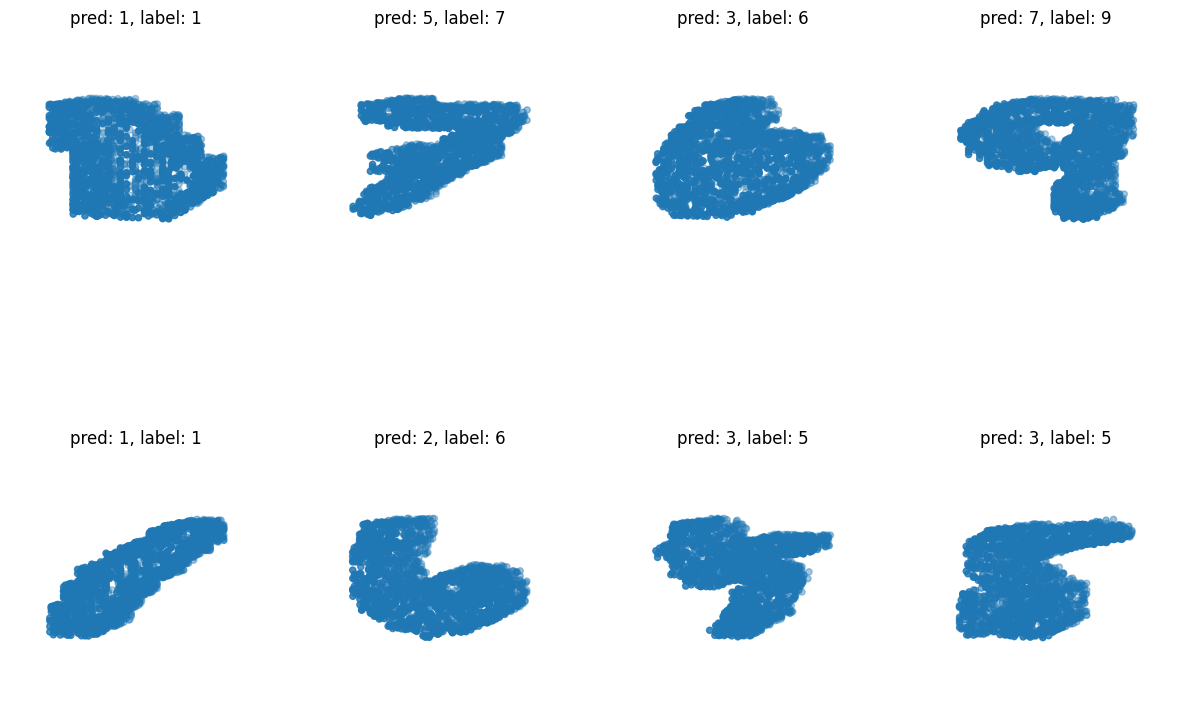

In [65]:
data = test_dataset_3d.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            preds[i].numpy(), labels.numpy()[i]
        )
    )
    ax.set_axis_off()
    ax.view_init(5, 15)
plt.show()


/Users/hshahriar/Desktop/GitHub Repos/multi-modal-sec/venv-mms/lib/python3.8/site-packages/matplotlib/text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


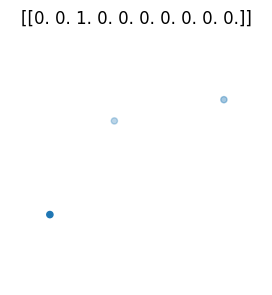

In [66]:
image = x_test_3d_sel[0:1]
label = y_test_sel_b[0:1]


# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(2, 4, i + 1, projection="3d")
ax.scatter(image[:, 0], image[:, 1], image[:, 2])
ax.set_axis_off()
ax.view_init(5, 15)
plt.title(label)
plt.show()

# image = tf.Tensor(image, dtype = float)
# label = tf.Tensor(label, dtype = float)

In [67]:
image = x_test_3d_sel[0:1]
label = y_test_sel_b[0:1]

image = tf.convert_to_tensor(image)
label = tf.convert_to_tensor(label)



In [68]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(model, input_image, input_label):
  
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

In [70]:
perturbations = create_adversarial_pattern(model, image, label)


1/1 [==============================] - 0s 36ms/step


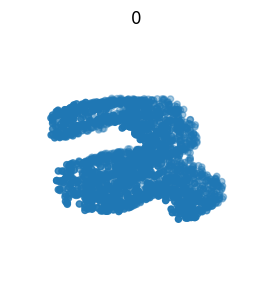

2 0.33128804
1/1 [==============================] - 0s 29ms/step


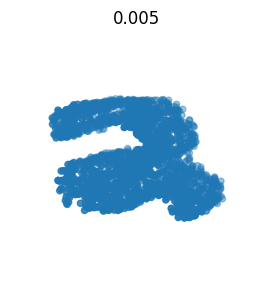

3 0.4962583
1/1 [==============================] - 0s 35ms/step


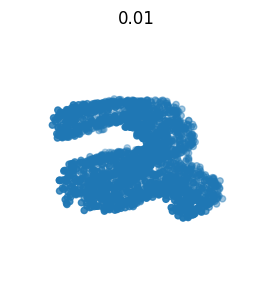

3 0.7286471
1/1 [==============================] - 0s 35ms/step


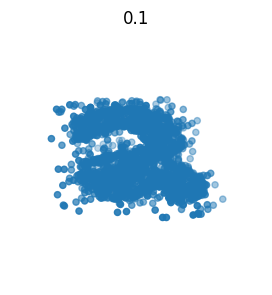

3 1.0


In [71]:
epsilons = [0, 0.005, 0.01, 0.1]

for eps in epsilons:

    del_x = perturbations.numpy() * eps

    adv_image = image + del_x


    # Predict and plot
    adv_pred = model.predict(adv_image)

    # plot points with predicted class and label
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(adv_image[0, :, 0], adv_image[0, :, 1], adv_image[0, :, 2])
    ax.set_axis_off()
    ax.view_init(5, 15)
    plt.title(eps)
    plt.show()
    
    print(np.argmax(adv_pred), np.max(adv_pred))

    

# Going with 2D Mnist dataset...

In [72]:
# Build the model

num_classes = 10
input_shape = (30, 30, 1)

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dropout_2 (Dropout)         (None, 2304)              0

In [73]:
# Train the model

batch_size = 128
epochs = 50

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x_train_2d_sel, y_train_sel_b, batch_size=batch_size, epochs=epochs, validation_split=0.1)


Epoch 1/50
1/1 [==============================] - 1s 807ms/step - loss: 2.2972 - accuracy: 0.0889 - val_loss: 2.2445 - val_accuracy: 0.1000
Epoch 2/50
1/1 [==============================] - 0s 60ms/step - loss: 2.2536 - accuracy: 0.2000 - val_loss: 2.2144 - val_accuracy: 0.1000
Epoch 3/50
1/1 [==============================] - 0s 56ms/step - loss: 2.2090 - accuracy: 0.1889 - val_loss: 2.1836 - val_accuracy: 0.1000
Epoch 4/50
1/1 [==============================] - 0s 57ms/step - loss: 2.1763 - accuracy: 0.2444 - val_loss: 2.1521 - val_accuracy: 0.1000
Epoch 5/50
1/1 [==============================] - 0s 56ms/step - loss: 2.1381 - accuracy: 0.1889 - val_loss: 2.1188 - val_accuracy: 0.1000
Epoch 6/50
1/1 [==============================] - 0s 55ms/step - loss: 2.1134 - accuracy: 0.2444 - val_loss: 2.0842 - val_accuracy: 0.1000
Epoch 7/50
1/1 [==============================] - 0s 60ms/step - loss: 2.0810 - accuracy: 0.2222 - val_loss: 2.0474 - val_accuracy: 0.1000
Epoch 8/50
1/1 [==========

1/1 [==============================] - 0s 63ms/step
pred: 2, label: 2
pred: 9, label: 9
pred: 3, label: 3
pred: 0, label: 0
pred: 7, label: 7
pred: 0, label: 0
pred: 1, label: 1
pred: 7, label: 7


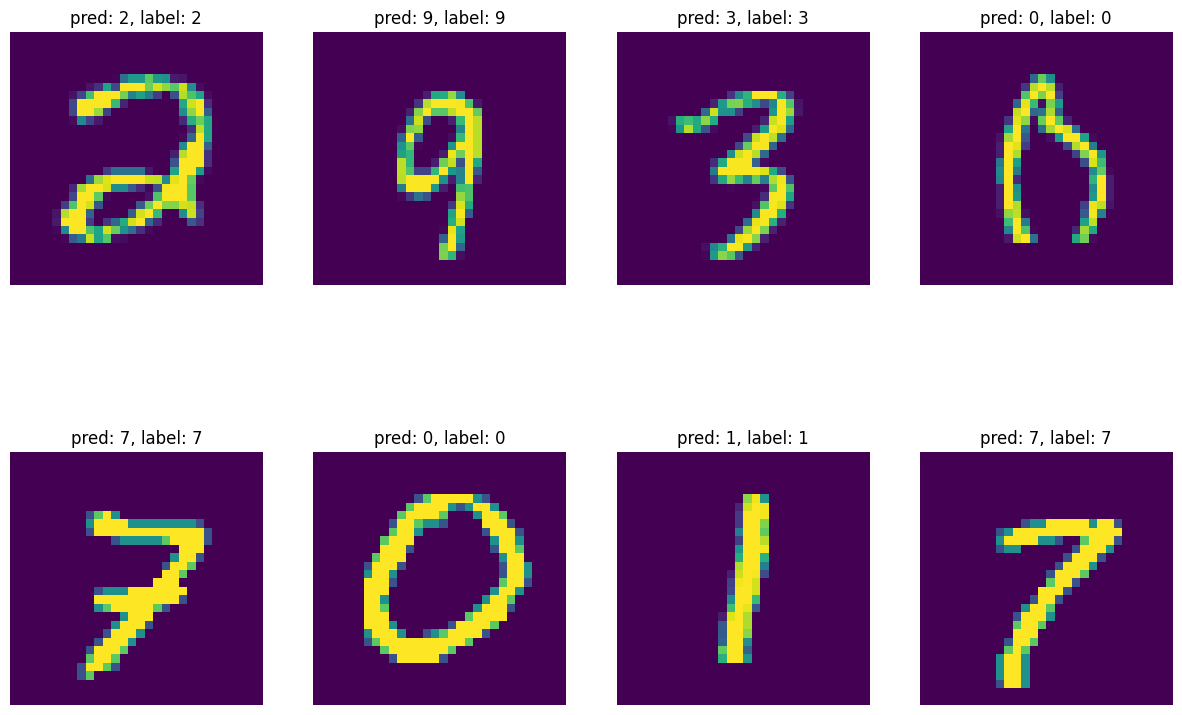

In [74]:
points, labels = x_test_2d_sel[-8:], y_test_sel_b[-8:]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)
labels = np.argmax(labels, axis = 1)


# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):

    print(f"pred: {preds[i].numpy()}, label: {labels[i]}") #.format(preds[i].numpy(), labels.numpy()[i])

    ax = fig.add_subplot(2, 4, i + 1)

    ax.imshow(points[i, :, :, 0])
    
    ax.set_title(
        "pred: {:}, label: {:}".format(
            preds[i].numpy(), labels[i]
        )
    )
    ax.set_axis_off()
plt.show()


1/1 [==============================] - 0s 24ms/step


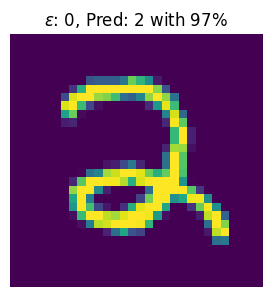

1/1 [==============================] - 0s 21ms/step


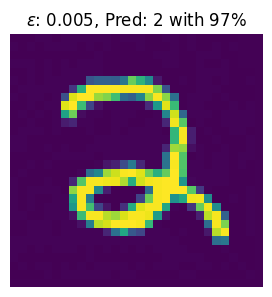

1/1 [==============================] - 0s 20ms/step


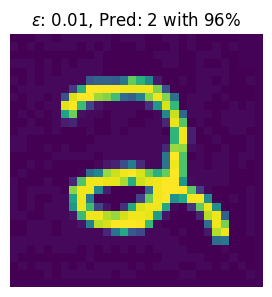

1/1 [==============================] - 0s 19ms/step


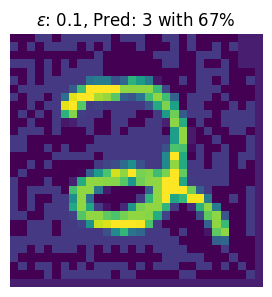

In [76]:
# Generating adversarial attacks for Mnist2d
# 
image = x_test_2d_sel[0:1]
label = y_test_sel_b[0:1]

image = tf.convert_to_tensor(image)
label = tf.convert_to_tensor(label)

perturbations = create_adversarial_pattern(model, image, label)

# epsilons = [0, 0.005, 0.01, 0.05]
epsilons = [0, 0.005, 0.01, 0.1]


for eps in epsilons:

    del_x = perturbations.numpy() * eps

    adv_image = image + del_x


    # Predict and plot
    adv_pred = model.predict(adv_image)
    adv_pred_int = np.argmax(adv_pred)
    adv_prob = int(np.max(adv_pred)*100)

    # plot points with predicted class and label
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(2, 4, i + 1)
    ax.imshow(adv_image[0, :, :, 0])
    ax.set_axis_off()
    plt.title(f"$\epsilon$: {eps}, Pred: {adv_pred_int} with {adv_prob}%")
    plt.show()
    

In [77]:
# Setup
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate

In [79]:
inputs_3D = keras.Input(shape=(NUM_POINTS, 3))
inputs_2D = (30, 30, 1)

# Extracting features from 3D points...
x = tnet(inputs_3D, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)
feat_3d = Model(inputs=inputs_3D, outputs=x)

# Extracting features from 2D points... 

feat_2d = keras.Sequential(
    [
        keras.Input(shape=inputs_2D),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
    ]
)

# Feature fusion from 3D points and 2D Image...


# combine the output of the two branches
combined = concatenate([feat_2d.output, feat_3d.output])
# apply a FC layer and then a regression prediction on the
z = Dense(64, activation="relu")(combined)
z = Dense(num_classes, activation="softmax")(z)


# Finally combine two models and build a single multi modal mode...
model_fusion = Model(inputs=[feat_2d.input, feat_3d.input], outputs=z,  name="mid-fusion")
model_fusion.summary()

Model: "mid-fusion"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d_22 (Conv1D)             (None, 2048, 32)     128         ['input_12[0][0]']               
                                                                                                  
 batch_normalization_34 (BatchN  (None, 2048, 32)    128         ['conv1d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 2048, 32)     0           ['batch_normalization_34

In [80]:
# Compiling fusion model...
# Train the model

batch_size = 24
epochs = 10

model_fusion.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model_fusion.fit([x_train_2d_sel, x_train_3d_sel], y_train_sel_b, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/10
4/4 [==============================] - 15s 2s/step - loss: 2.4200 - accuracy: 0.1667 - val_loss: 1.9194 - val_accuracy: 0.4000
Epoch 2/10
4/4 [==============================] - 7s 2s/step - loss: 2.0460 - accuracy: 0.2889 - val_loss: 1.7878 - val_accuracy: 0.6000
Epoch 3/10
4/4 [==============================] - 6s 2s/step - loss: 1.7759 - accuracy: 0.4556 - val_loss: 1.6590 - val_accuracy: 0.5000
Epoch 4/10
4/4 [==============================] - 7s 2s/step - loss: 1.6069 - accuracy: 0.4222 - val_loss: 1.4127 - val_accuracy: 0.5000
Epoch 5/10
4/4 [==============================] - 7s 2s/step - loss: 1.3103 - accuracy: 0.6111 - val_loss: 0.8767 - val_accuracy: 0.7000
Epoch 6/10
4/4 [==============================] - 7s 2s/step - loss: 0.9781 - accuracy: 0.7556 - val_loss: 1.1847 - val_accuracy: 0.7000
Epoch 7/10
4/4 [==============================] - 7s 2s/step - loss: 0.7269 - accuracy: 0.7889 - val_loss: 0.7194 - val_accuracy: 0.7000
Epoch 8/10
4/4 [========================

1/1 [==============================] - 0s 74ms/step
pred: 2, label: 2
pred: 5, label: 5
pred: 7, label: 7
pred: 1, label: 1


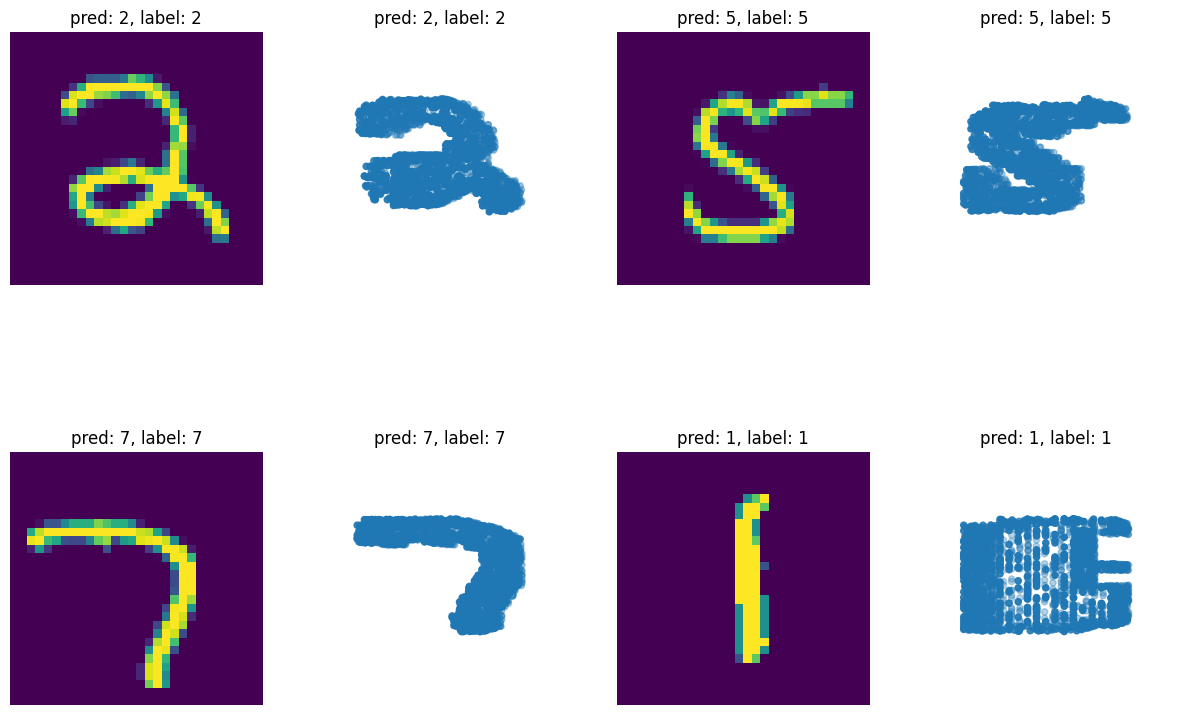

In [95]:
# Visualize predictions and images...

images, points, labels = x_test_2d_sel[:4], x_test_3d_sel[:4], y_test_sel_b[:4]

# run test data through model
preds = model_fusion.predict([images, points])
preds = tf.math.argmax(preds, -1)
labels = np.argmax(labels, axis = 1)


# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(4):

    print(f"pred: {preds[i].numpy()}, label: {labels[i]}") #.format(preds[i].numpy(), labels.numpy()[i])

    ax = fig.add_subplot(2, 4, 2*i + 1)
    ax.imshow(images[i, :, :, 0])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            preds[i].numpy(), labels[i]
        )
    )
    ax.set_axis_off()

    ax = fig.add_subplot(2, 4, 2*i + 2, projection="3d")    
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            preds[i].numpy(), labels[i]
        )
    )
    ax.set_axis_off()
    ax.view_init(0, 10)
plt.show()


In [121]:
# Create adversarial samples...
images, points, labels = x_test_2d_sel[-1:], x_test_3d_sel[-1:], y_test_sel_b[-1:]
input_sample = [tf.convert_to_tensor(images[0:1]), tf.convert_to_tensor(points[0:1])]
input_label = tf.convert_to_tensor(labels[0:1])

loss_object = tf.keras.losses.CategoricalCrossentropy()


# def create_adversarial_pattern(model, input_image, input_label):
# return purturbatiuon
# perturbations = create_adversarial_pattern(model, image, label)

  
with tf.GradientTape() as tape:
  tape.watch(input_sample)
  prediction = model_fusion(input_sample)
  loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_sample)
  # Get the sign of the gradients to create the perturbation
  perturbations_sign_2d = tf.sign(gradient[0]).numpy()
  perturbations_sign_3d = tf.sign(gradient[1]).numpy()
# Visualize purturbation...

1/1 [==============================] - 0s 36ms/step


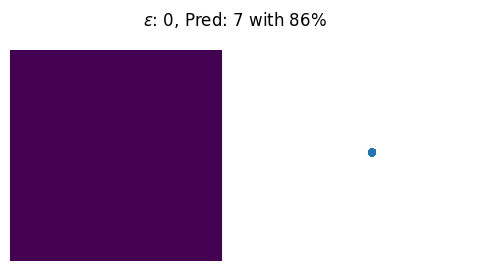

1/1 [==============================] - 0s 26ms/step


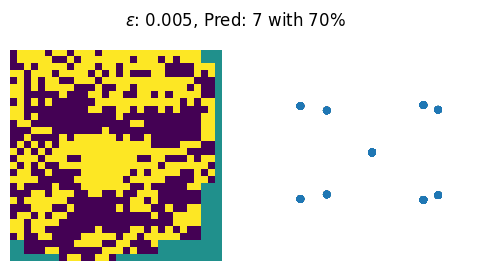

1/1 [==============================] - 0s 33ms/step


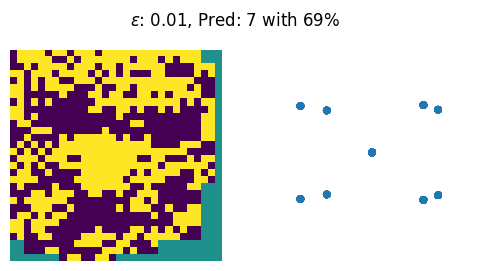

1/1 [==============================] - 0s 28ms/step


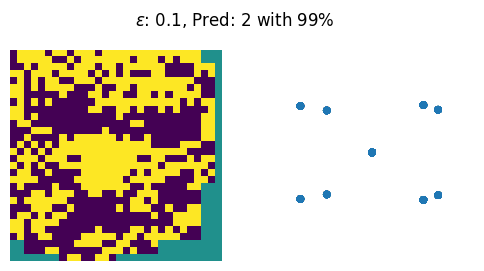

1/1 [==============================] - 0s 31ms/step


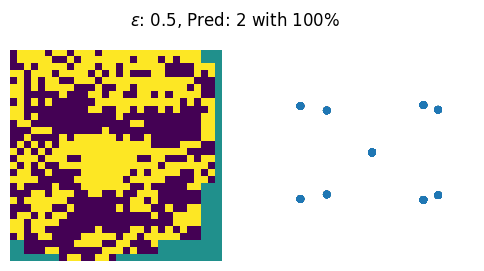

1/1 [==============================] - 0s 31ms/step


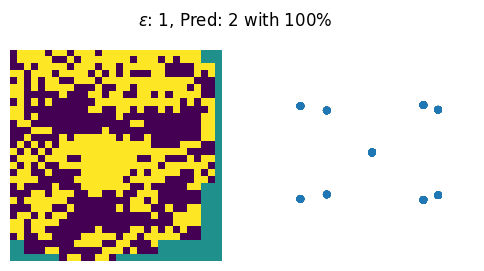

In [125]:
# epsilons = [0, 0.005, 0.01, 0.05]
epsilons = [0, 0.005, 0.01, 0.1, 0.5, 1] #, 10, 100]

for eps in epsilons:

    eps_2d = eps
    eps_3d = eps

    del_x_2d = perturbations_sign_2d * eps_2d
    del_x_3d = perturbations_sign_3d * eps_3d

    adv_image = images + del_x_2d
    adv_point = points + del_x_3d

    # Predict and plot
    adv_pred = model_fusion.predict([adv_image, adv_point])
    adv_pred_int = np.argmax(adv_pred)
    adv_prob = int(np.max(adv_pred)*100)

    # plot points with predicted class and label
    fig = plt.figure(figsize=(6, 3))
    
    # Plotting 2D images...
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(del_x_2d[0, :, :, 0])
    # ax.set_title("Adversarial image")
    ax.set_axis_off()

    # Plotting 3D clound points...
    ax = fig.add_subplot(1, 2, 2, projection="3d")    
    ax.scatter(del_x_3d[0, :, 0], del_x_3d[0, :, 1], del_x_3d[0, :, 2])
    # ax.set_title("Adversarial point clouds")
    ax.set_axis_off()
    ax.view_init(0, 10)

    fig.suptitle(f"$\epsilon$: {eps}, Pred: {adv_pred_int} with {adv_prob}%")
    plt.show()

In [123]:
del_x_3d

array([[[-1.,  1., -1.],
        [ 1., -1.,  1.],
        [-1., -1.,  1.],
        ...,
        [ 0.,  0.,  0.],
        [ 1.,  1., -1.],
        [ 0.,  0.,  0.]]])

In [124]:
points

array([[[-0.15      ,  0.21502525,  0.02474747],
        [ 0.08793103, -0.05997475, -0.02525253],
        [ 0.10862069,  0.44002525,  0.37474747],
        ...,
        [ 0.0362069 ,  0.19002525,  0.26224747],
        [ 0.06724138, -0.30997475,  0.28724747],
        [-0.06724138, -0.30997475, -0.55025253]]])

In [120]:
# Predict and plot
adv_pred = model_fusion.predict([adv_image, adv_point])

print(adv_pred)

adv_pred_int = np.argmax(adv_pred)

print(adv_pred_int)

adv_prob = int(np.max(adv_pred)*100)

print(adv_prob)

1/1 [==============================] - 0s 37ms/step
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
2
100


In [107]:
adv_image.shape

(1, 30, 30, 1)

In [108]:
adv_point.shape

(1, 2048, 3)

In [26]:
# Creating a fusion model....

# define two sets of inputs
inputA = Input(shape=(32,))
inputB = Input(shape=(128,))
# the first branch operates on the first input
x = Dense(8, activation="relu")(inputA)
x = Dense(4, activation="relu")(x)

x = Model(inputs=inputA, outputs=x)

# the second branch opreates on the second input
y = Dense(64, activation="relu")(inputB)
y = Dense(32, activation="relu")(y)
y = Dense(4, activation="relu")(y)


y = Model(inputs=inputB, outputs=y)


# combine the output of the two branches
combined = concatenate([x.output, y.output])
# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(2, activation="relu")(combined)
z = Dense(1, activation="relu")(z)
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input], outputs=z)

model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 dense_16 (Dense)               (None, 64)           8256        ['input_6[0][0]']                
                                                                                                  
 dense_14 (Dense)               (None, 8)            264         ['input_5[0][0]']                
                                                                                            

In [27]:
import numpy as np
x_A = np.random.randn(100, 32)
x_B = np.random.randn(100, 128)
y = np.array([0, 1]*50)
y

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

In [29]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
# model.fit(x_train_3d_sel, y_train_sel_b, batch_size=batch_size, epochs=epochs, validation_split=0.1)

In [30]:
model.fit([x_A, x_B], y, batch_size=10, epochs=5, validation_split=0.1)

Epoch 1/5
9/9 [==============================] - 1s 22ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 2/5
9/9 [==============================] - 0s 5ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 3/5
9/9 [==============================] - 0s 5ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 4/5
9/9 [==============================] - 0s 5ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 5/5
9/9 [==============================] - 0s 5ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000


In [31]:
model.predict([x_A[:10], x_B[:10]])

1/1 [==============================] - 0s 82ms/step


array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [36]:
# Generating adversarial attacks for Mnist2d
# 
import tensorflow as tf
# image = [x_A[0:1], x_B[0:1]]
label = y[:1]

# image = tf.convert_to_tensor(image)
# label = tf.convert_to_tensor(label)

image = [tf.convert_to_tensor(x_A[0:1]), tf.convert_to_tensor(x_B[0:1])]
label = tf.convert_to_tensor(label)


loss_object = tf.keras.losses.BinaryCrossentropy()

input_image = image
input_label = label

# def create_adversarial_pattern(model, input_image, input_label):
  
with tf.GradientTape() as tape:
  tape.watch(input_image)
  prediction = model(input_image)
  loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  # signed_grad = tf.sign(gradient)


# perturbations = create_adversarial_pattern(model, image, label)


In [39]:
tf.sign(gradient[0])

<tf.Tensor: shape=(1, 32), dtype=float64, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])>

In [40]:
tf.sign(gradient[1])

<tf.Tensor: shape=(1, 128), dtype=float64, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])>

In [25]:
# from keras.utils import plot_model
# plot_model(model, to_file='plots/fusion_AB.jpg', show_shapes = True, show_layer_names = True)

In [ ]:
# import seaborn as sns
# sns.heatmap(pd.DataFrame(x_train_2d[0,:, :, 0]))

In [ ]:
# Train the model

batch_size = 128
epochs = 5

# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
# model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=["sparse_categorical_accuracy"])


# model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
model.fit(train_dataset_2d, epochs = 5, validation_data=test_dataset_2d)

In [ ]:
# Set up
import numpy as np
from tensorflow import keras
from keras import layers

In [ ]:
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
# import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)
# # your code

In [ ]:
# Prepare the data

num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train_sel, num_classes)
y_test = keras.utils.to_categorical(y_test_sel, num_classes)

In [ ]:
import seaborn as sns
sns.heatmap(pd.DataFrame(x_train[0,:, :, 0]))

In [ ]:
y_test

In [ ]:
x_train_2d = x_train_2d.reshape(-1, 30, 30, 1)
x_test_2d = x_test_2d.reshape(-1, 30, 30, 1)


In [ ]:
# Prepare the data

num_classes = 10
input_shape = (30, 30, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
# Build the model

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

In [ ]:
# Train the model

batch_size = 128
epochs = 5

# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
# model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=["sparse_categorical_accuracy"])


# model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
model.fit(train_dataset_2d, epochs = 5, validation_data=test_dataset_2d)


In [ ]:
#Save model...
model.save('models/mnist2d')

In [ ]:
# Evaluate the trained model
model = keras.models.load_model('models/mnist2d')

score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])